In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.nn.functional import relu
from torchvision import transforms,models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

#train and test data directory
train_dir = "data/images/train/"
trainval_dir = "data/images/trainval/"
val_dir = "data/images/val/"


#load the train data
dataset_train = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

#load the test data
dataset_trainval = ImageFolder(trainval_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

#load the validation data
dataset_val = ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

In [3]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [8]:
import test_u_net

def run(Unet):
    num_class = 6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet(num_class).to(device)

    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
    model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=300)

    model.eval()  # Set model to the evaluation mode

    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
    ])
    # # Create another simulation dataset for test
    test_dataset = SimDataset(3, transform = trans)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

    # Get the first batch
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Predict
    pred = model(inputs)
    # The loss functions include the sigmoid function.
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    print(pred.shape)

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
    pred_rgb = [masks_to_colorimg(x) for x in pred]

    plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

True
Epoch 0/299
----------
LR 1e-05


/home/toldo/miniconda3/envs/rai_py38_poetry_enn/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.673879, dice: 0.990964, loss: 0.832422
val: bce: 0.672425, dice: 0.990580, loss: 0.831502
saving best model
0m 2s
Epoch 1/299
----------
LR 1e-05
train: bce: 0.671569, dice: 0.990952, loss: 0.831260
val: bce: 0.670169, dice: 0.990567, loss: 0.830368
saving best model
0m 1s
Epoch 2/299
----------
LR 1e-05
train: bce: 0.669363, dice: 0.990940, loss: 0.830151
val: bce: 0.668067, dice: 0.990555, loss: 0.829311
saving best model
0m 1s
Epoch 3/299
----------
LR 1e-05
train: bce: 0.667394, dice: 0.990929, loss: 0.829161
val: bce: 0.666433, dice: 0.990546, loss: 0.828490
saving best model
0m 1s
Epoch 4/299
----------
LR 1e-05
train: bce: 0.665888, dice: 0.990922, loss: 0.828405
val: bce: 0.665013, dice: 0.990539, loss: 0.827776
saving best model
0m 1s
Epoch 5/299
----------
LR 1e-05
train: bce: 0.664463, dice: 0.990915, loss: 0.827689
val: bce: 0.663596, dice: 0.990532, loss: 0.827064
saving best model
0m 1s
Epoch 6/299
----------
LR 1e-05
train: bce: 0.663040, dice: 0.990908, lo

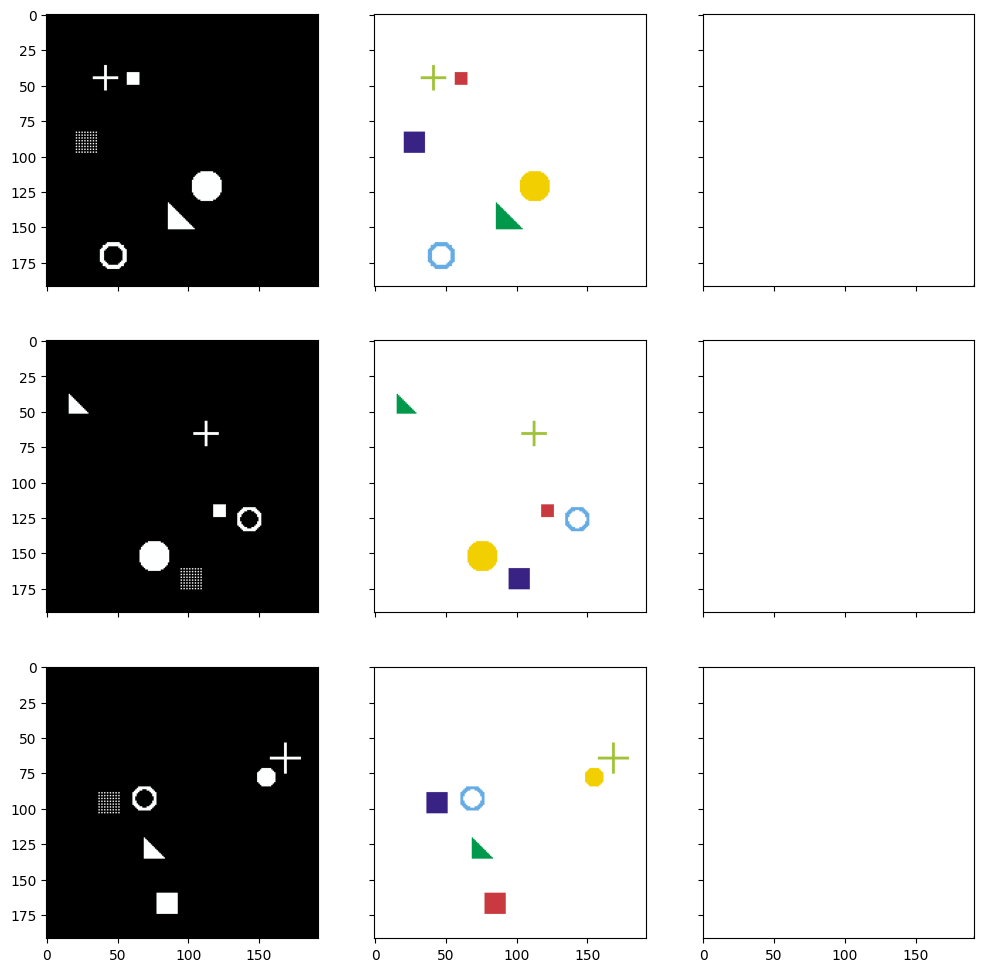

In [4]:
test_u_net.run(UNet)

# Dice Loss
---
The Dice coefficient, or Dice-Sørensen coefficient, is a common metric for pixel segmentation that can also be modified to act as a loss function:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

In [13]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# BCE-Dice Loss
---
This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combining the two methods allows for some diversity in the loss, while benefitting from the stability of BCE. The equation for multi-class BCE by itself will be familiar to anyone who has studied logistic regression:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/80f87a71d3a616a0939f5360cec24d702d2593a2)

In [12]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE